# Tutorial 2: more advanced optical systems and ray-tracing options.
In the previous tutorial we built a simple optical system consisting of a paraboloid. We then performed a ray-trace from the initial frame of rays to the paraboloid surface, and from the paraboloid we found the focus of the frame by calling the `s.findRTfocus()` method. We did all of this using the tubular ray-trace frame input.

In this tutorial, we will introduce Gaussian ray-trace frames. We will then create an optical setup that is slightly more advanced, where we try to generate a collimated beam from a Gaussian ray-trace beam.   

In [1]:
#%matplotlib notebook # Uncomment for interactive plots when running the notebook!

import numpy as np

from PyPO.System import System
from PyPO.Enums import Projections, Objects

s = System()

2025-08-28 14:59:09 - WARNING - System override set to True. 


2025-08-28 14:59:09 - WORK - Generating Gaussian ray-trace beam. 
2025-08-28 14:59:09 - WORK - ... Sampling ... 
2025-08-28 14:59:13 - WORK - Succesfully sampled 5000 rays: 3.1403839588165283 seconds. 
2025-08-28 14:59:13 - INFO - Added Gaussian frame start to system. 
2025-08-28 14:59:13 - INFO - Translated frame start by ('0.000e+00', '0.000e+00', '1.000e+02') millimeters. 


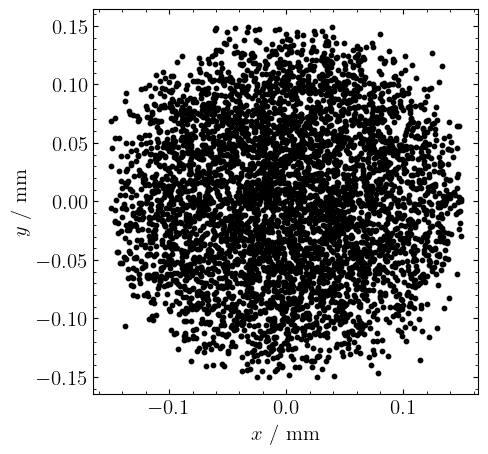

In [2]:
RTpar = {
        "name"      : "start",
        "nRays"     : 5000,
        "lam"       : 0.01,
        "n"         : 1,
        "seed"      : 0,
        "x0"        : 0.05,
        "y0"        : 0.05
        }

s.createGRTFrame(RTpar)
s.translateGrids("start", np.array([0, 0, 100]), obj=Objects.FRAME)
s.plotRTframe("start", project=Projections.xy)

We start by defining a Gaussian ray-trace frame. The frame is created by [rejection sampling](https://en.wikipedia.org/wiki/Rejection_sampling) a Gaussian distribution of positions and directions for the rays. In the frame dictionary, we specify the number of rays "nRays" in the frame, the wavelength "lam" of the light in millimeters, the refractive index "n" of the medium, the seed for the sampling and the $1/e$ beamwidths "x0" and "y0" along the x- and y-axis. This frame is then translated by 100 millimeters along the z-axis.

2025-08-28 14:59:13 - INFO - Added ellipsoid ellipsoid to system. 
2025-08-28 14:59:13 - INFO - Added plane plane_t to system. 
2025-08-28 14:59:13 - INFO - Rotated element plane_t by ('4.500e+01', '0.000e+00', '0.000e+00') degrees around ('0.000e+00', '0.000e+00', '0.000e+00'). 
2025-08-28 14:59:13 - INFO - Added paraboloid paraboloid to system. 
2025-08-28 14:59:13 - INFO - Added plane plane_out to system. 
2025-08-28 14:59:13 - INFO - Rotated element plane_out by ('0.000e+00', '-9.000e+01', '0.000e+00') degrees around ('0.000e+00', '0.000e+00', '0.000e+00'). 
2025-08-28 14:59:13 - INFO - Translated element plane_out by ('5.000e+01', '-1.200e+02', '0.000e+00') millimeters. 


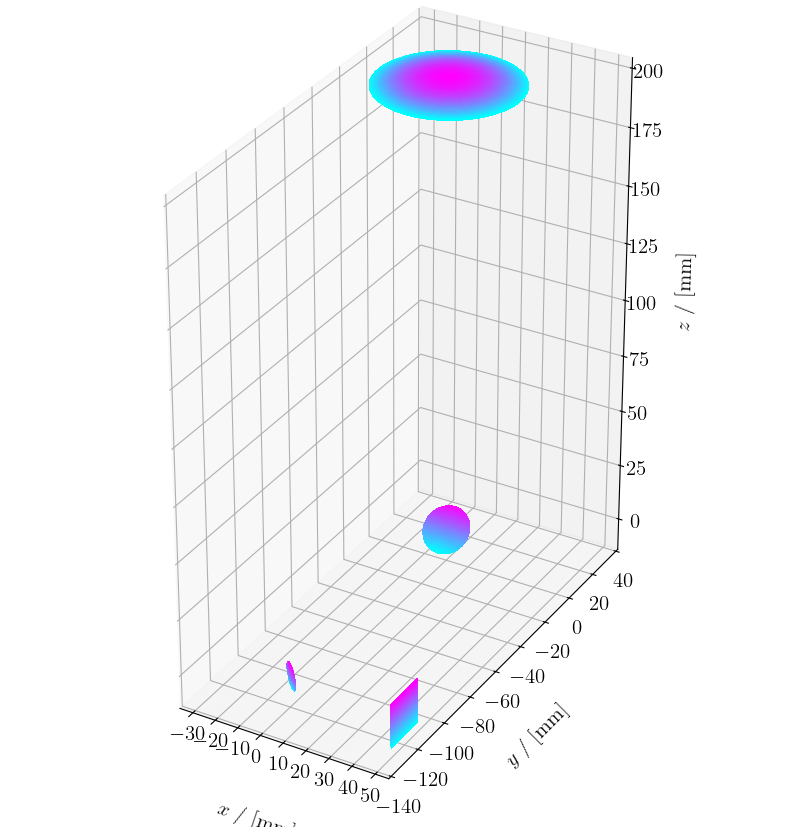

In [3]:
ellipse = {
            "name"      : "ellipsoid",
            "pmode"     : "focus",
            "gmode"     : "uv",
            "flip"      : True,
            "focus_1"   : np.array([0, 0, 100]),
            "focus_2"   : np.array([0, 0, -100]),
            "orient"    : "z",
            "ecc"       : 0.5,
            "lims_u"    : np.array([0, 30]),
            "lims_v"    : np.array([0, 360]),
            "gridsize"  : np.array([801, 800])
            }

s.addEllipse(ellipse)

plane_t = {
            "name"      : "plane_t",
            "gmode"     : "uv",
            "lims_u"    : np.array([0, 10]),
            "lims_v"    : np.array([0, 360]),
            "gridsize"  : np.array([801, 800])
            }

s.addPlane(plane_t)
s.rotateGrids("plane_t", np.array([45, 0, 0]))

parabola = {
            "name"      : "paraboloid",
            "pmode"     : "focus",
            "gmode"     : "uv",
            "focus_1"   : np.array([0, -100, 0]),
            "vertex"    : np.array([-10, -100, 0]),
            "lims_u"    : np.array([0, 5]),
            "lims_v"    : np.array([0, 360]),
            "gcenter"   : np.array([0,-20]),
            "gridsize"  : np.array([801, 800])
            }

s.addParabola(parabola)

plane_out = {
            "name"      : "plane_out",
            "gmode"     : "xy",
            "lims_x"    : np.array([-10, 10]),
            "lims_y"    : np.array([-10, 10]),
            "gridsize"  : np.array([801, 801])
            }

s.addPlane(plane_out)
s.rotateGrids("plane_out", np.array([0, -90, 0]))
s.translateGrids("plane_out", np.array([50, -120, 0]))

s.plotSystem()

We added several optical elements to the setup. First, we added an ellipsoid reflector. The focii are placed at z=100 and z=-100. Because we translated the Gaussian frame earlier, the frame is now situated in the upper focus of the ellipsoid. The semi-major axis of the ellipsoid is oriented along the z-axis by setting "orient" to "z". 

The second element, "plane_t", is a tilted plane. This plane is situated at $z = 0$ and is tilted by 45 degrees around the x-axis. This mirror essentially folds the lower focus of the ellipsoid to lie along the negative y-axis.

After the tilted plane, we place an off-axis paraboloid reflector.
The focus of the paraboloid is placed in the lower ellipse focus, after being folded by the tilted plane.

The final element is a plane placed after the paraboloid, along the x-axis. We terminate the ray-trace in this plane and inspect the results.

We can inspect the designed system by calling the `s.plotSystem()` method. This plots all elements in the current `System` object.

2025-08-28 14:59:16 - WORK - *** Starting RT propagation *** 
2025-08-28 14:59:16 - WORK - Hardware: running 15 CPU threads. 
2025-08-28 14:59:16 - WORK - ... Calculating ... 
2025-08-28 14:59:16 - WORK - *** Finished: 0.018 seconds *** 
2025-08-28 14:59:16 - WORK - *** Starting RT propagation *** 
2025-08-28 14:59:16 - WORK - Hardware: running 15 CPU threads. 
2025-08-28 14:59:16 - WORK - ... Calculating ... 
2025-08-28 14:59:16 - WORK - *** Finished: 0.018 seconds *** 
2025-08-28 14:59:16 - WORK - *** Starting RT propagation *** 
2025-08-28 14:59:16 - WORK - Hardware: running 15 CPU threads. 
2025-08-28 14:59:16 - WORK - ... Calculating ... 
2025-08-28 14:59:16 - WORK - *** Finished: 0.017 seconds *** 
2025-08-28 14:59:16 - WORK - *** Starting RT propagation *** 
2025-08-28 14:59:16 - WORK - Hardware: running 15 CPU threads. 
2025-08-28 14:59:16 - WORK - ... Calculating ... 
2025-08-28 14:59:16 - WORK - *** Finished: 0.021 seconds *** 
2025-08-28 14:59:16 - INFO - Added plane focal_p

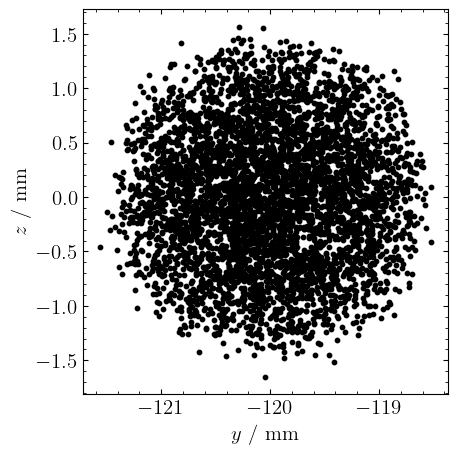

In [4]:
start_ell_RT = {
            "fr_in"     : "start",
            "t_name"    : "ellipsoid",
            "fr_out"    : "fr_ell",
            "device"    : "CPU",
            "tol"       : 1e-6
            }

s.runRayTracer(start_ell_RT)

ell_plane_t_RT = {
            "fr_in"     : "fr_ell",
            "t_name"    : "plane_t",
            "fr_out"    : "fr_plane_t",
            "device"    : "CPU",
            "tol"       : 1e-6
            }

s.runRayTracer(ell_plane_t_RT)

plane_t_par_RT = {
            "fr_in"     : "fr_plane_t",
            "t_name"    : "paraboloid",
            "fr_out"    : "fr_par",
            "device"    : "CPU",
            "t0"        : 120,
            "tol"       : 1e-6
            }

s.runRayTracer(plane_t_par_RT)

par_plane_out_RT = {
            "fr_in"     : "fr_par",
            "t_name"    : "plane_out",
            "fr_out"    : "fr_out",
            "device"    : "CPU",
            "tol"       : 1e-6
            }

s.runRayTracer(par_plane_out_RT)
s.findRTfocus("fr_plane_t")
s.plotRTframe("fr_out", project=Projections.yz)

The propagations are similar to the one in the previous tutorial, albeit a bit more plentiful. It is good to note that for the propagation from the tilted plane to the paraboloid, we specify the "t0" parameter. This is the initial guess for the distance of the ray-surface intersection from the origin of the ray. Because we select, in this case, the section from the part of the paraboloid that is furthest away from the tilted plane, the ray-tracer will first encounter the closer part of the paraboloid. This is more easily imagined when we remember that, after transforming the paraboloid and incoming frame into the paraboloid restframe, the frame is essentially illuminating the full paraboloid from the side. If we did not change "t0", the ray-tracer would instead intersect in the closest half of the paraboloid (to see this, just set t0 to 1 and repeat the propagation).

To plot the rays and optical elements together, we call `s.plotSystem()` again, but now passing the 'RTframes' argument. This is a list containing the frames to be plotted. The frames are connected in the order in which they are passed to `s.plotSystem()`.

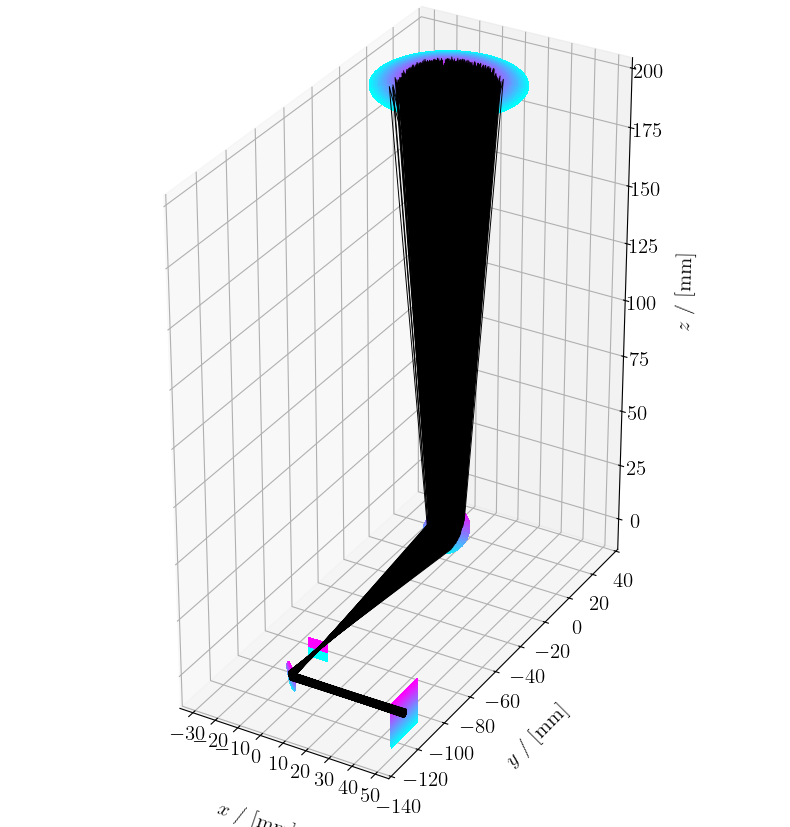

In [5]:
s.plotSystem(RTframes=["start", "fr_ell", "fr_plane_t", "fr_par", "fr_out"])